In recent years, the forecasting of stock prices has become a key area of interest in financial markets. In this assignment, we aim to forecast the future stock price of Apple.

complete the code cells based on the following **Steps:**

1. **Library Installation**: First, install the `yfinance` library.

2. **Data Download**: Download stock prices of Apple using the `download` function in `yfinance`. Use the AAPL symbol and set the data range from `2019-01-01` to `2025-01-01`. Use data up to `2025-01-01` for training and after that date for testing.

3. **Plotting Data**: To verify the above steps, plot this data over time, assigning different colors to training and testing data points.


4. **Data Normalization**: For better model training, normalize the values on the y-axis. Use the `MinMaxScaler` function from the `scikit-learn` library, with only the training data as the basis for scaling both the training and testing datasets.

5. **Data Preparation**: Prepare the data required for model training and testing. Define a variable representing the number of previous data points to use for predictions (e.g., if set to 60, each prediction considers the past 60 data points). Based on this example, the dataset dimensions would be:
   - `X_train.shape`: (n, 60, 1) (where n is the number of training samples)
   - `y_train.shape`: (n,)

6. **Model Creation (Two Versions)**:

Implement two PyTorch models:
- `(A) Vanilla LSTM`
   - 4 LSTM layers, each with 50 hidden units
   - After each LSTM: Dropout with rate 0.2
   - Final layer: Linear(50 → 1)

- `(B) Bidirectional LSTM`
   - Same as above, but each LSTM layer is bidirectional
   - Hidden state size doubles

7. **Model Training**:
   - **Loss Function**: Mean Squared Error (MSE)
   - **Optimizer**: Adam
   - **Epochs**: 100
   - **Batch Size**: 32

8. **Prediction and Plotting**: After training, make predictions on the test data for both models and plot the predictions alongside the actual values. The plot should have time on the x-axis, and different colors for actual and predicted values.

**Questions**:
1. Explain the advantages or disadvantages of increasing or decreasing the defined variable (the number of previous data points) for model training.
2. **Vanilla vs Bidirectional LSTM**:
Compare the test performance (MAE, RMSE) of the two models.
Then explain:
   - Why might one perform better than the other on stock data?
   - When would you prefer bidirectional LSTM?
   - When would you avoid it (e.g., real-time forecasting)?


**Answers**
1. Explain the advantages or disadvantages of increasing or decreasing the defined variable (the number of previous data points) for model training.

* When you increase the sequence length, you feed the model more past data at every prediction. This will gives you more context meaning model sees long-term trneds. But it is harder to train becuase it requires higher computations. Also it has risk of overfitting and in the stock predictions very old data is not usefull.

* when you decrese the sequence length, you feed the model less historical context. Is it faster and model focuses on recent movements. But it mights forgets long-term patterns and if the context is too short it is too risky in front of the noise data.

---

2. **Vanilla vs Bidirectional LSTM:** Compare the test performance (MAE, RMSE) of the two models. Then explain:
Why might one perform better than the other on stock data?
When would you prefer bidirectional LSTM?
When would you avoid it (e.g., real-time forecasting)?

* In my case Vanilla LSTM works better. Bidirectional LSTM leaks future information, but during real forecasting we does not have those future information (i.e. Stock data is forward-dependent).

* Bidirectional LSTM works well on tasks where entire sequence nedd to be known before prediction, like NLP text classification, Sentiment analysis, etc. But in forecasting task Vanilla LSTM is more suitable than Bidirectional one because future context is unavailable.

## Imports

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Set Defaults & Globals
Set default conditions for some libraries and Global Variables

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use 'cuda' if available else 'cpu'

## Download data & EDA
Check out the data.
You can check out the data yourself more.

In [3]:
aapl_data = yf.download('AAPL', start='2019-01-01', end='2025-10-27')
# Use only Close price
aapl_data = aapl_data[['Close']].copy()
aapl_data.reset_index(inplace=True)

/tmp/ipython-input-1968003274.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_data = yf.download('AAPL', start='2019-01-01', end='2025-10-27')
[*********************100%***********************]  1 of 1 completed


In [4]:
# TODO: Split the data based on date
train_data = aapl_data[aapl_data['Date'] < '2025-01-01']
test_data  = aapl_data[aapl_data['Date'] >= '2025-01-01']

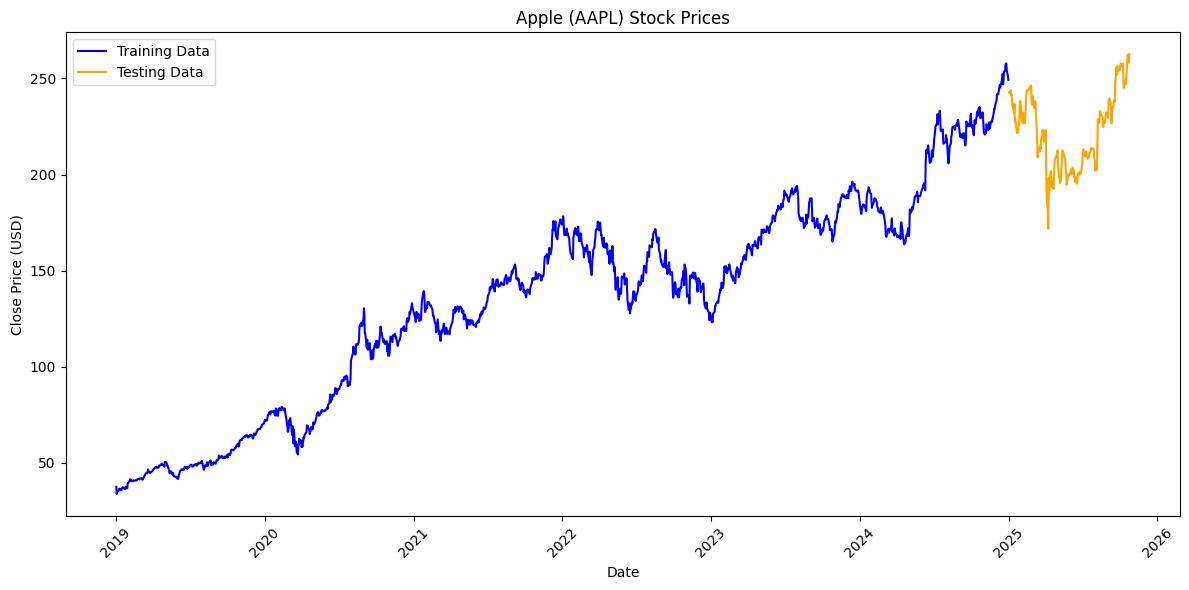

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data', color='blue')
plt.plot(test_data['Date'],  test_data['Close'],  label='Testing Data',  color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Apple (AAPL) Stock Prices')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
train_data.head()

Price,Date,Close
Ticker,,AAPL
0,2019-01-02,37.538815
1,2019-01-03,33.799679
2,2019-01-04,35.242561
3,2019-01-07,35.164120
4,2019-01-08,35.834454


## Preprocessing

In [7]:
# TODO: Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))
test_scaled  = scaler.transform(test_data['Close'].values.reshape(-1, 1))

Define the sequence length (e.g., 60 previous data points). Create sequences for training and testing.

In [8]:
#TODO Set the sequence length
SEQ_LEN = 60

def create_sequences(data, seq_len):
    X, y = [], []
    # TODO: Complete the loop to build sequences
    for i in range(len(data) - seq_len):
        seq_x = data[i:i + seq_len]
        seq_y = data[i + seq_len]
        X.append(seq_x) # past seq_len values
        y.append(seq_y) # next value (target)
    return np.array(X), np.array(y)

# ---- Train / Validation split inside training set (80/20) ----
train_size = int(len(train_scaled) * 0.8)
val_size   = len(train_scaled) - train_size

train_part = train_scaled[:train_size].flatten()
val_part   = train_scaled[train_size:].flatten()

# TODO: Create train, validation, and test sequences
X_train, y_train = create_sequences(train_part, SEQ_LEN)
X_val,   y_val   = create_sequences(val_part, SEQ_LEN)
X_test,  y_test  = create_sequences(test_scaled.flatten(), SEQ_LEN)

# Add feature dimension: (samples, timesteps, 1)
# TODO: Expand dimensions for LSTM input
X_train = np.expand_dims(X_train, axis=-1)
X_val   = np.expand_dims(X_val, axis=-1)
X_test  = np.expand_dims(X_test, axis=-1)

# Convert to torch tensors
# TODO: Convert NumPy arrays to torch.float32 tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val   = torch.from_numpy(X_val).float()
y_val   = torch.from_numpy(y_val).float()
X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).float()

# Create Dataset and DataLoader objects
# TODO: Wrap into TensorDataset and create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Model Creation (Vanilla LSTM)
Define a PyTorch LSTM model as explained at the start of the notebook (4 stacked LSTM layers with 50 units each, dropout 0.2 after each, followed by a dense layer).

In [9]:
class AAPLLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout=0.2):
        super(AAPLLSTM, self).__init__()
        # TODO: Define 4 LSTM layers + dropout + final linear layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.drop1 = nn.Dropout(p=dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.drop2 = nn.Dropout(p=dropout)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.drop3 = nn.Dropout(p=dropout)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.drop4 = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # TODO: Pass input through all 4 LSTM+Dropout blocks
        #       Then apply linear layer on the LAST timestep
        #       Return the prediction
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)
        out = self.drop2(out)
        out, _ = self.lstm3(out)
        out = self.drop3(out)
        out, _ = self.lstm4(out)
        out = self.drop4(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [10]:
# TODO: Instantiate the model, loss function and optimizer
model = AAPLLSTM()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Model Training
Train the model using MSE loss, Adam optimizer, 100 epochs, and batch size 32.

In [11]:
epochs = 100

for epoch in range(epochs):
    # ---- Train ----
    # TODO: TRAINING PHASE (COMPLETE THE CODE)
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs  = inputs.to(device)
        labels  = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(inputs)
        loss  = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ---- Validate ----
    # TODO: VALIDATION PHASE (COMPLETE THE CODE)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            preds  = model(inputs)
            loss   = criterion(preds, labels)
            val_loss += loss.item()

    print(f'Epoch {epoch+1:3d}/{epochs} | '
          f'Train Loss: {train_loss/len(train_loader):.6f} | '
          f'Val Loss:   {val_loss/len(val_loader):.6f}')

Epoch   1/100 | Train Loss: 0.134733 | Val Loss:   0.357926
Epoch   2/100 | Train Loss: 0.022006 | Val Loss:   0.036259
Epoch   3/100 | Train Loss: 0.080476 | Val Loss:   0.173609
Epoch   4/100 | Train Loss: 0.047049 | Val Loss:   0.204828
Epoch   5/100 | Train Loss: 0.038938 | Val Loss:   0.170917
Epoch   6/100 | Train Loss: 0.033835 | Val Loss:   0.132444
Epoch   7/100 | Train Loss: 0.039071 | Val Loss:   0.127865
Epoch   8/100 | Train Loss: 0.038357 | Val Loss:   0.131987
Epoch   9/100 | Train Loss: 0.037155 | Val Loss:   0.120434
Epoch  10/100 | Train Loss: 0.031742 | Val Loss:   0.062312
Epoch  11/100 | Train Loss: 0.027081 | Val Loss:   0.050575
Epoch  12/100 | Train Loss: 0.018020 | Val Loss:   0.050465
Epoch  13/100 | Train Loss: 0.016538 | Val Loss:   0.066231
Epoch  14/100 | Train Loss: 0.010313 | Val Loss:   0.071280
Epoch  15/100 | Train Loss: 0.012215 | Val Loss:   0.093274
Epoch  16/100 | Train Loss: 0.010510 | Val Loss:   0.078351
Epoch  17/100 | Train Loss: 0.010548 | V

## Prediction and Plotting

In [12]:
# TODO: Generate predictions on test set and inverse-scale
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test.to(device))

# Inverse transform
y_test_actual      = scaler.inverse_transform(y_test.unsqueeze(1).numpy())
predictions_actual = scaler.inverse_transform(predictions_scaled.reshape(-1, 1).cpu().numpy())

# Corresponding dates (skip first SEQ_LEN points in test set)
test_start_idx = len(test_data) - len(y_test)
test_dates     = test_data['Date'].iloc[test_start_idx:].reset_index(drop=True)

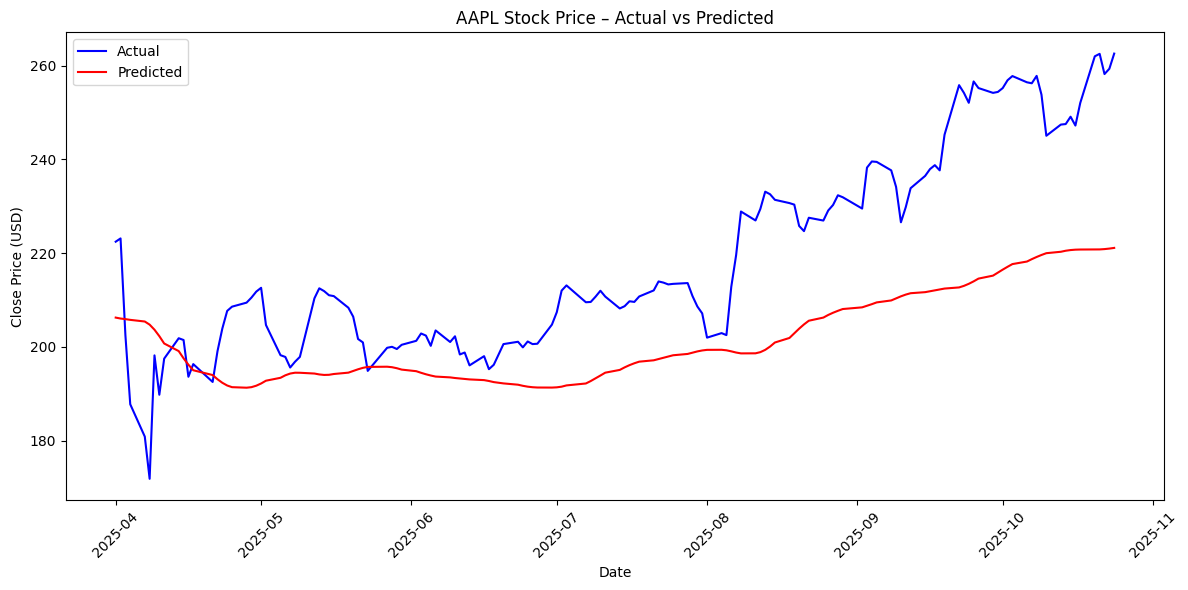

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual,     label='Actual',   color='blue')
plt.plot(test_dates, predictions_actual, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('AAPL Stock Price – Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Creation (Bidirectional LSTM)

In [14]:
# BIDIRECTIONAL LSTM MODEL
class AAPLBiLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, dropout=0.2):
        super(AAPLBiLSTM, self).__init__()
        # TODO: Define 4 bidirectional LSTM layers with dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.drop1 = nn.Dropout(p=dropout)
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        self.drop2 = nn.Dropout(p=dropout)
        self.lstm3 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        self.drop3 = nn.Dropout(p=dropout)
        self.lstm4 = nn.LSTM(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        self.drop4 = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        # TODO: Forward pass through 4 bidirectional LSTM + dropout layers
        #       Use only the LAST timestep for prediction
        out, _ = self.lstm1(x)
        out = self.drop1(out)
        out, _ = self.lstm2(out)
        out = self.drop2(out)
        out, _ = self.lstm3(out)
        out = self.drop3(out)
        out, _ = self.lstm4(out)
        out = self.drop4(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [15]:
# TODO: Instantiate the bidirectional model, optimizer and loss function
model_bi = AAPLBiLSTM()
model_bi = model_bi.to(device)
criterion = nn.MSELoss()
optimizer_bi = torch.optim.Adam(model_bi.parameters(), lr=0.001)

## Model Training (Bidirectional LSTM)

In [16]:
from torch.autograd import backward
# Train Bidirectional Model
print("\nTraining Bidirectional LSTM...")

# TODO: Complete the training loop for the bidirectional model
#       Same structure as vanilla
for epoch in range(epochs):
    model_bi.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        optimizer_bi.zero_grad()
        preds = model_bi(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer_bi.step()
        train_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        model_bi.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                preds = model_bi(inputs)
                val_loss += criterion(preds, labels).item()
        print(f'BiLSTM  | Epoch {epoch+1:3d} | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}')


Training Bidirectional LSTM...
BiLSTM  | Epoch  20 | Train Loss: 0.002734 | Val Loss: 0.018447
BiLSTM  | Epoch  40 | Train Loss: 0.002027 | Val Loss: 0.006693
BiLSTM  | Epoch  60 | Train Loss: 0.001842 | Val Loss: 0.007370
BiLSTM  | Epoch  80 | Train Loss: 0.002323 | Val Loss: 0.009729
BiLSTM  | Epoch 100 | Train Loss: 0.001308 | Val Loss: 0.004574


## Prediction and Plotting (Bidirectional LSTM)

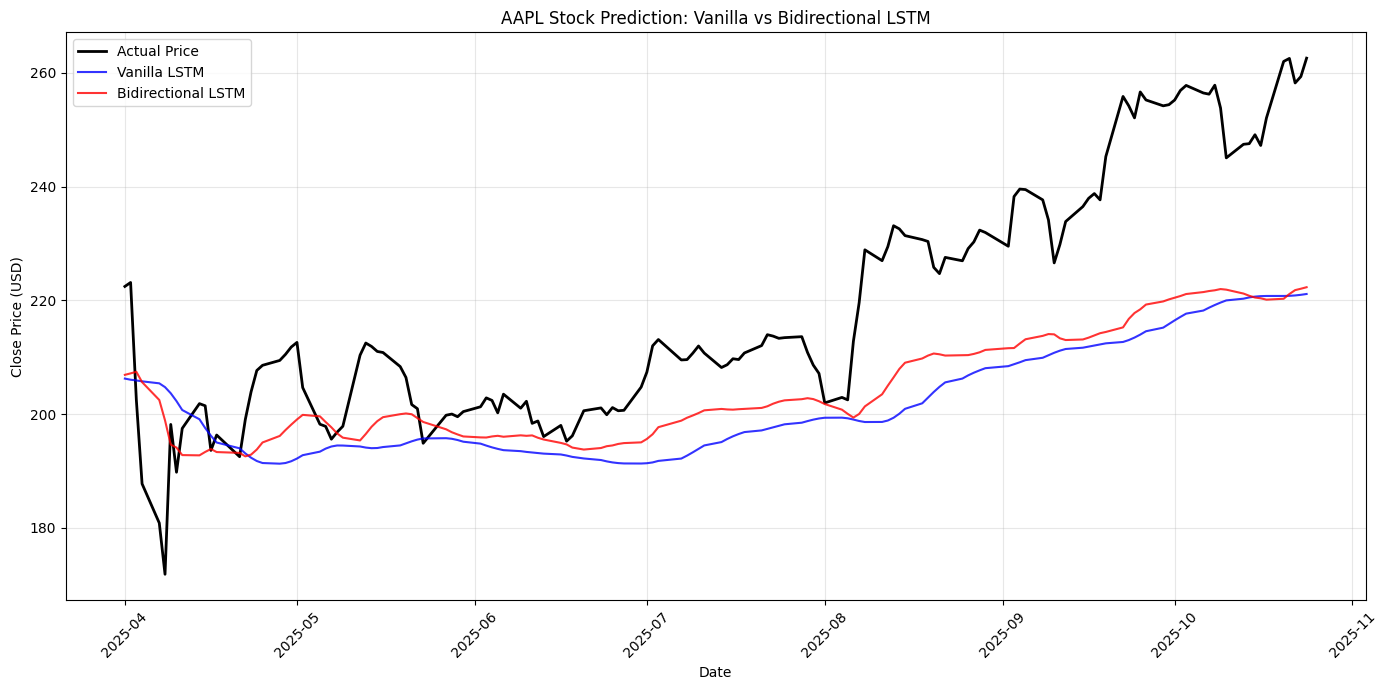

In [17]:
# Predictions from BOTH models
model.eval()
model_bi.eval()

# TODO: Get predictions from both models on test set
with torch.no_grad():
    pred_uni_scaled = model(X_test.to(device))
    pred_bi_scaled  = model_bi(X_test.to(device))

# Inverse transform
y_test_actual = scaler.inverse_transform(y_test.unsqueeze(1).numpy())
pred_uni = scaler.inverse_transform(pred_uni_scaled.reshape(-1, 1).cpu().numpy())
pred_bi  = scaler.inverse_transform(pred_bi_scaled.reshape(-1, 1).cpu().numpy())

# Test dates
test_start_idx = len(test_data) - len(y_test)
test_dates = test_data['Date'].iloc[test_start_idx:].reset_index(drop=True)

# Plot: Actual vs Vanilla LSTM vs Bidirectional LSTM
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='black', linewidth=2)
plt.plot(test_dates, pred_uni,      label='Vanilla LSTM', color='blue', alpha=0.8)
plt.plot(test_dates, pred_bi,       label='Bidirectional LSTM',  color='red',  alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('AAPL Stock Prediction: Vanilla vs Bidirectional LSTM')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()